# Predicting House Prices in Ames, IA

![housesbanner.png](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

This notebook contain my submission for the [House Price Prediction competition on Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). In this project I will take you through my process of cleaning the data and the decisions made in the process.

Briefly explained, the project asks you to predict the sale price of homes in Aimes, IA, based on 79 descriptive characteristics. They range from the usual ones you'd find in a real estate flyer, down to type of foundation, electrical, materials used, etc.


For the sake of brevity, some insights applied in the code are product of the hindsight when I notice something in the data that can be elegantly solved somewhere earlier in the process of creating this code.

#### Part 1: Loading and cleaning the data

Short section where I get the data ready for visualizations and feature creation/model building. This dataset is already highly curated, so the fixes were short.
<br>
<br>

#### Part 2: Visualization

Using the resulting data frame, I will create a few visualizations I think will help better show how the data relates to itself.
<br>
<br>

#### Part 3: Feature creation

Columns that can preserve their relation numerically will be coded and other will be made into dummies with each entry having a column/feature with a binary option. Monolithic, incomplete, or otherwise useless columns where the predictive power/data is present in another column.
<br>
<br>

#### Part 4: Modeling

Cross validation of the data to check the model's integity and scoring. The converted results will be then 'expanded' from the normalization applied, and zipped into a csv file with the ID numbers for submission.
<br>
<br>


#### Part 1: Loading and cleaning the data


In [54]:
import pandas as pd
import numpy as np

%matplotlib inline

In [55]:
dforigin = pd.read_csv("../train.csv")
dforigintest = pd.read_csv("../test.csv")

We begin by looking at the number of missing per feature. This gives us a good idea of how much work we'll have to do per column. 
<br>
<br>
For the purposes of this exercise (and since we're lucky enough to have the test/evaluation data available), I will perform the Exploratory Data Analysis on both data sets simultaneously.
<br>

In [56]:
# Function to check the number of missing per quantitative feature
def num_miss(df):
    nulls = pd.DataFrame(df.describe())
    nomissing = []

    for feat in nulls.columns:
        nomissing.append(df.shape[0] - nulls[feat].iloc[0])

    missfeat = pd.DataFrame(zip(nulls.columns, nomissing), columns=['Feature', 'Missing'])
    missfeat = missfeat.sort_values('Missing', ascending=False).head(12)
    return missfeat

print("Missing in train data \n", num_miss(dforigin), '\n\n Missing in test data\n', num_miss(dforigintest))

Missing in train data 
           Feature  Missing
2     LotFrontage    259.0
25    GarageYrBlt     81.0
8      MasVnrArea      8.0
0              Id      0.0
29    OpenPorchSF      0.0
22   KitchenAbvGr      0.0
23   TotRmsAbvGrd      0.0
24     Fireplaces      0.0
26     GarageCars      0.0
27     GarageArea      0.0
28     WoodDeckSF      0.0
30  EnclosedPorch      0.0 

 Missing in test data
          Feature  Missing
2    LotFrontage    227.0
25   GarageYrBlt     78.0
8     MasVnrArea     15.0
18  BsmtHalfBath      2.0
17  BsmtFullBath      2.0
10    BsmtFinSF2      1.0
26    GarageCars      1.0
27    GarageArea      1.0
12   TotalBsmtSF      1.0
11     BsmtUnfSF      1.0
9     BsmtFinSF1      1.0
22  KitchenAbvGr      0.0


In [57]:
# 81 missing values in the training data are garage related. Checking with other garage 
# variables to see if it corresponds to 'no garage'  
pd.set_option('display.max_rows', None)
print((dforigin.loc[dforigin.GarageCars== 0].index == dforigin.loc[dforigin.GarageYrBlt.isnull()].index).sum())
print((dforigin.loc[dforigin.MasVnrType.isnull()].index == dforigin.loc[dforigin.MasVnrType.isnull()].index).sum())

81
8



LotFrontage missing numbers are high enough that I'm discarding as a feature. Most of the predictive power of the feature is probably contained within other lot related metrics, such as area and neighborhood.
<br>
<br>
Checking the next highest missing data 'GarageYrBlt', I cross checked with other garage related data and realized the null value was another way to code not having a garage. Representing the lack of a garage with zeroes in GarageCars and GarageArea should preserve the signal in this feature, while deleting it. However, it doesnt match as nicely in the test data. This creates uncertainty in how to fill the missing values. Still, considering other garage features, I feel confident dropping this feature without losing signal.
<br>
<br>
A similar situation is happening with MasVnrArea, where NaNs were used in a few entries to indicate the lack of masonry in the veneer. This happens to be the most common entry in the data, so I will replace NaNs in MasVnrArea with value 0. 
<br>
<br>


In [58]:
# Sanity testing that the multiple missing values have the same index
print((dforigintest.loc[dforigintest.BsmtHalfBath.isnull()].index == dforigintest.loc[dforigintest.BsmtFullBath.isnull()].index).sum())

2


The test data had a few more obstacles in the data, but they all correspond to data inputters using NaNs to interpret not having a feature; something I will be interpreting as value 0.
<br>

In [59]:
dforigin.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Looking at my base statistics of my quantitative features, I can make several decisions about the data and which features to take closer looks at. For brevity, I will summarize them in bullet points:
<br> 
<br> 
- BsmtFin* have a lot of zero values and doesn't say much about the property. Same with BsmtFull/HalfBath; the values contain so many zeroes that it is best to just use TotalBsmtSF as the signal for basement.
<br> 

- In the vast majority of the cases, GrLivArea = 1stFlrSF + 2ndFlrSF, but not always. GrLivArea also includes low quality finished living area, a feature that is very uncommon. To reflect the area of the house, I will use a created feature that adds 1stFlrSF + 2ndFlrSF, and dropinng GrLivArea as a feature. There is a high max falue in GrLivArea, so I will drop properties with LivingSF over 4000 to improve the model.
<br> 

- TotRmsAbvGrd is a very strange metric when talking about Real Estate. It corresponds to a mix of bedrooms, bathrooms, and kitchens. That being said, the signal will be preserve in all of those, justifying a drop of the feature without losing much information.
<br> 

- Most deck related features are in zeroes. Only OpenPorchSF seem to have any signal, and even then just at that 75%tile and above. Dropping all porch features.
<br> 

- Although numeric, years and months in real estate is more a category than a number. For that reason a better metric that won't bias a model is the age at time of sale, resulting from subtracting YearSold from YearBuilt. Similarly, MoSold will be converted into a qualitative feature.
<br> 

In [60]:
# Creating the features mentioned above and dropping their 'parents'

dforigin[['AgeAtSale', 'LivingSF']] = np.nan
dforigintest[['AgeAtSale', 'LivingSF']] = np.nan
for i in range(0, dforigin.shape[0]):
    dforigin.AgeAtSale.iloc[i] = dforigin.YrSold.iloc[i] - dforigin.YearBuilt.iloc[i]
    dforigin.LivingSF.iloc[i] = int(dforigin['1stFlrSF'].iloc[i] + dforigin['2ndFlrSF'].iloc[i])
    
for i in range(0, dforigintest.shape[0]):
    dforigintest.AgeAtSale.iloc[i] = dforigintest.YrSold.iloc[i] - dforigintest.YearBuilt.iloc[i]
    dforigintest.LivingSF.iloc[i] = int(dforigintest['1stFlrSF'].iloc[i] + dforigintest['2ndFlrSF'].iloc[i])
    
# Dropping the parents, as well as other feature I have discussed above why to remove.
    
dftrain = dforigin.drop(['YrSold', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
                         'GarageYrBlt', 'GarageFinish', 'GarageType', 'GarageQual', 'GarageCond',
                         'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                         'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
                         'TotRmsAbvGrd', 'WoodDeckSF'], axis=1)

dftest = dforigintest.drop(['YrSold', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
                            'GarageYrBlt', 'GarageFinish', 'GarageType', 'GarageQual', 
                            'GarageCond', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 
                            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
                            'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotRmsAbvGrd', 
                            'WoodDeckSF'], axis=1)


# Turning numeric months and MSSubClass into categories by turning them into strings

dftrain.MoSold = dftrain.MoSold.apply(str)
dftest.MoSold = dftest.MoSold.apply(str)

dftrain.MSSubClass = dftrain.MSSubClass.apply(str)
dftest.MSSubClass = dftest.MSSubClass.apply(str)

# Targetting outliers by capping the size of living area to 4000 sqft for model creation

index_todrop = dftrain.loc[dftrain.LivingSF >= 4000].index
dftrain.drop(index_todrop, inplace=True)

/home/andygon/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [61]:
# Secondary script to get more information on data types and size of features, focusing on qualitative

def eda_helper(df):
    temp_maxrows = pd.get_option("display.max_rows")
    pd.set_option("display.max_rows", None)
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        dict_.update({"null_count" : data.isnull().sum()})
        dict_.update({"unique_count" : len(data.unique())})
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
    eda_df = eda_df.sort_values(['null_count','unique_count'], ascending=[True, False])
    
    pd.set_option("display.max_rows", temp_maxrows)
    return eda_df.sort_values(by='null_count', ascending=False)

eda_helper(dftrain).head(20)


,null_count,unique_count,data_type
PoolQC,1451,4,"{float, str}"
MiscFeature,1402,5,"{float, str}"
Alley,1365,3,"{float, str}"
Fence,1176,5,"{float, str}"
FireplaceQu,690,6,"{float, str}"
LotFrontage,259,110,{float}
MasVnrArea,8,325,{float}
MasVnrType,8,5,"{float, str}"
Electrical,1,6,"{float, str}"
FullBath,0,4,{int}


In [62]:
eda_helper(dftest).head(35)

,null_count,unique_count,data_type
PoolQC,1456,3,"{float, str}"
MiscFeature,1408,4,"{float, str}"
Alley,1352,3,"{float, str}"
Fence,1169,5,"{float, str}"
FireplaceQu,730,6,"{float, str}"
LotFrontage,227,116,{float}
MasVnrType,16,5,"{float, str}"
MasVnrArea,15,304,{float}
MSZoning,4,6,"{float, str}"
Utilities,2,2,"{float, str}"


Similarly, now we look at qualitative data above. Right off the bat we see a lot of features with high null counts. Given these numbers I can safely drop: PoolQC, MiscFeature, Alley, Fence, and, FireplaceQu.
<br>

In [63]:
#Function to take in df and output df listing the features and the percentage of same response

def top_response(df):
    homgen = pd.DataFrame(columns=['Feature', 'Top Response', 'Pct of Responses'])
    for feat in df.columns:
        vals = df[feat].value_counts(dropna=False, normalize=True)
        homgen = homgen.append({'Feature':feat, 'Top Response':vals.index[0], 'Pct of Responses':vals.iloc[0]}, ignore_index=True)
    
    return homgen.sort_values(by='Pct of Responses', ascending=False)

top_response(dftrain)

,Feature,Top Response,Pct of Responses
9,Utilities,AllPub,0.999313
51,PoolQC,NaN,0.996566
50,PoolArea,0,0.996566
5,Street,Pave,0.995879
14,Condition2,Norm,0.990385
21,RoofMatl,CompShg,0.983516
48,3SsnPorch,0,0.983516
34,LowQualFinSF,0,0.982143
30,Heating,GasA,0.978022
54,MiscVal,0,0.964286


In [64]:
top_response(dftest)

,Feature,Top Response,Pct of Responses
9,Utilities,AllPub,0.998629
51,PoolQC,NaN,0.997944
5,Street,Pave,0.995888
50,PoolArea,0,0.995888
30,Heating,GasA,0.991090
48,3SsnPorch,0,0.991090
34,LowQualFinSF,0,0.990404
14,Condition2,Norm,0.989719
21,RoofMatl,CompShg,0.988348
54,MiscVal,0,0.965045


Features with too high homogeneity bias the model. In this case, after checking the features' homogeneity, I feel comfortable dropping every feature above 80% same response rate. Every other feature will be evaluated individually, but the goal is to simplify the amount of features for a better model without losing information. This is not some sort of standard, but a decision based on the value of offending features to our model.
<br>


I will also impute the small number of missing values to avoid issues in the model fitting. Categorical data will be imputed with the mode, numeric with a zero.

In [65]:
# Setting up a list of features to drop from the data according to the criteria above.
def drops(df):
    drop1 = top_response(df)
    drop2 = eda_helper(df)
    return list(set([i for i in drop1[drop1['Pct of Responses'] > .8]['Feature']] + [i for i in drop2[drop2.null_count > 200].index]))

dftrain_drops = drops(dftrain)
dftest_drops = drops(dftest)

dftrain.drop(dftrain_drops, axis=1, inplace=True)
dftest.drop(dftest_drops, axis=1, inplace=True)

In [66]:
# Converting features that are in a string-based scale into a numeric scale to analyze as quantitative features

scale_from_6 = sorted(list(range(6)), reverse=True)
rating_from_top = ['Ex','Gd','TA','Fa','Po', np.nan]
vars_to_scale = ['HeatingQC', 'KitchenQual']

for i in vars_to_scale:
    dftrain[i].replace(rating_from_top, scale_from_6, inplace=True)
    dftest[i].replace(rating_from_top, scale_from_6, inplace=True)

In [67]:
# Feature KitchenAbvGr was not included since skewness deteriorated when transformed. This was done retroactively.
quant_feats = ['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'FullBath' , 'HalfBath', 
               'BedroomAbvGr', 'Fireplaces', 'GarageCars', 'GarageArea', 'OpenPorchSF', 
               'AgeAtSale', 'TotalBsmtSF', 'LivingSF', 'HeatingQC', 'KitchenQual']

qual_feats = ['MSSubClass', 'MSZoning', 'LotShape', 'Neighborhood', 'HouseStyle', 'MoSold', 
              'Foundation', 'LotConfig', 'Exterior1st', 'Exterior2nd', 'MasVnrType']

In [68]:
# Imputing values into null values in the remainding features.

# Train data first. Fewer problems
dftrain['MasVnrType'] = dftrain['MasVnrType'].fillna(dftrain['MasVnrType'].mode()[0])
dftrain['MasVnrArea'] = dftrain['MasVnrArea'].fillna(0)

# Test data had more nulls to deal with, per eda_helper()
dftest['MasVnrType'] = dftest['MasVnrType'].fillna(dftest['MasVnrType'].mode()[0])
dftest['MasVnrArea'] = dftest['MasVnrArea'].fillna(0)
dftest['MSZoning'] = dftest['MSZoning'].fillna(dftest['MSZoning'].mode()[0])
dftest['GarageCars'] = dftest['GarageCars'].fillna(0)
dftest['GarageArea'] = dftest['GarageArea'].fillna(0)
dftest['TotalBsmtSF'] = dftest['TotalBsmtSF'].fillna(0)
dftest['Exterior1st'] = dftest['Exterior1st'].fillna(dftest['Exterior1st'].mode()[0])
dftest['Exterior2nd'] = dftest['Exterior2nd'].fillna(dftest['Exterior2nd'].mode()[0])


#### Part 2: Visualization


To visually understand the data, we begin with a correlation heatmap, which will let us know with values and gradient color, the most correlated features with our target variable. 
<br>
The final decision on feature selection for quantitative variables will be dependent on these values; so will the choice of variables for the informational graphs after the heatmap. These graphs helps us visually understand the relation between area, price, and other common characteristics of living spaces.
<br>

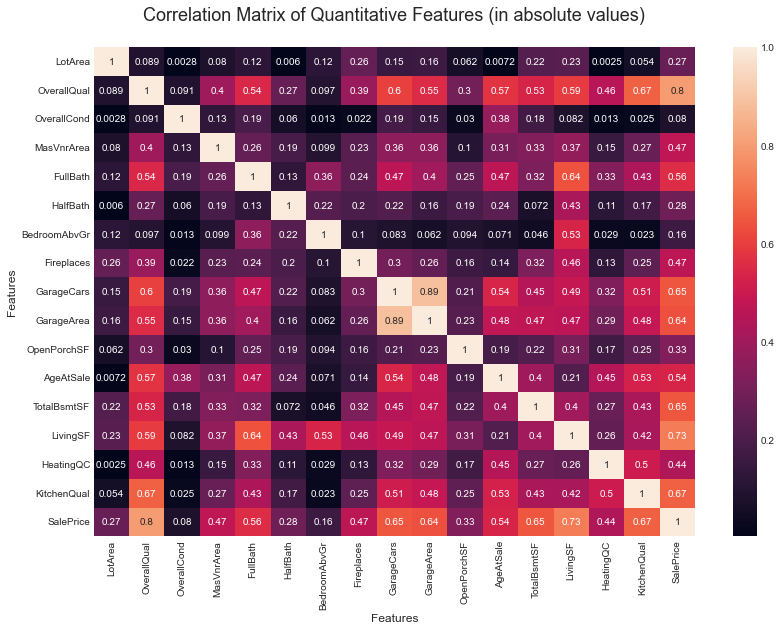

In [69]:
import seaborn as sns
from matplotlib import pyplot as plt

dfviz = pd.concat([dftrain[quant_feats], dforigin.SalePrice], axis=1)

plt.figure(figsize=(12,9))
sns.heatmap(abs(dfviz.corr()), annot=True)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Matrix of Quantitative Features (in absolute values)\n', size=18);


<br>
Looking at the correlation values of other variables vs our target variable, SalePrice, we can see the top correlations exist with OverallQual, LivingSF, GarageCars/Area, TotalBsmtSF, FullBath, and AgeAtSale. Everything else has under 0.5 correlation value, making the poor candidates for a predictive model. 
<br>

They will stay in the dataframe and undergo transformation, but most with low values will be removed before model creation.
<br>

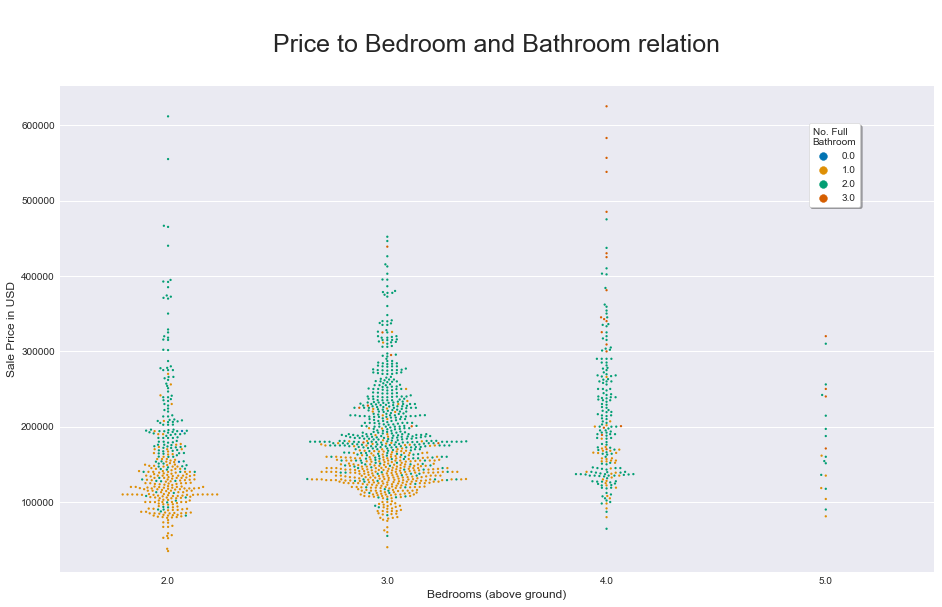

In [70]:
sns.set_style('darkgrid')
plt.figure(figsize=(14,9))
swarm = sns.swarmplot(x='BedroomAbvGr', y='SalePrice', data = dfviz, hue='FullBath', 
            palette='colorblind', size=2.3)
plt.xlim(1.5,5.5)
plt.xlabel('Bedrooms (above ground)')
plt.ylabel('Sale Price in USD')
swarm.legend(title='No. Full\nBathroom', shadow=True, facecolor='white', bbox_to_anchor= (.92,.93))
plt.title('\nPrice to Bedroom and Bathroom relation\n', size=25);

<Figure size 720x576 with 0 Axes>

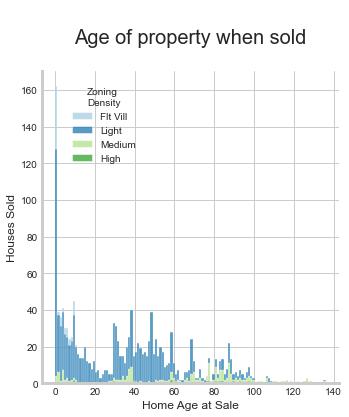

In [71]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
dis = sns.displot(x='AgeAtSale', data=pd.concat([dfviz, dforigin.MSZoning],axis=1), bins= len(dfviz['AgeAtSale'].value_counts()), 
                  hue='MSZoning', hue_order=['FV', 'RL', 'RM', 'RH'], multiple='stack',
                 palette='Paired')
plt.ylabel('Houses Sold')
plt.xlabel('Home Age at Sale')
plt.title('\nAge of property when sold\n', size=20)
dis._legend.set_title('Zoning\nDensity')
new_labels = ['Flt Vill', 'Light', 'Medium' , 'High']
for t, l in zip(dis._legend.texts, new_labels): t.set_text(l)
dis._legend.set_bbox_to_anchor([0.35,0.81])
plt.show()

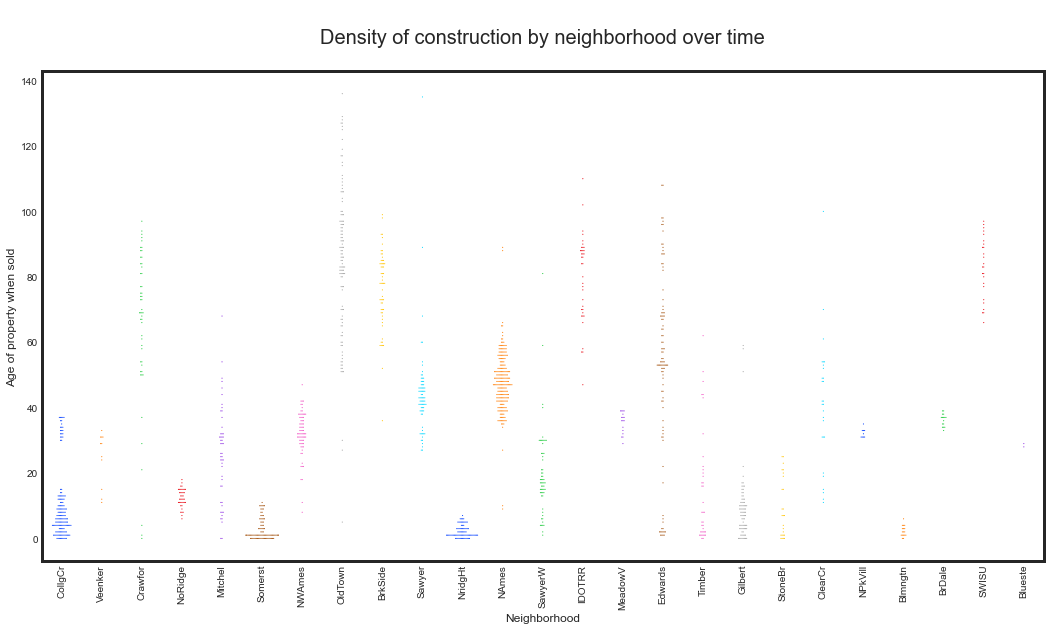

In [72]:
plt.figure(figsize=(16,9))
sns.set_style('ticks')
neighswarm = sns.swarmplot(x='Neighborhood', y='AgeAtSale', 
                           data=pd.concat([dfviz, dforigin.Neighborhood], axis=1), 
                           size=1.1, palette='bright')
plt.xticks(rotation='vertical')
plt.title('\nDensity of construction by neighborhood over time\n', size=20)
plt.ylabel('Age of property when sold')
plt.show()

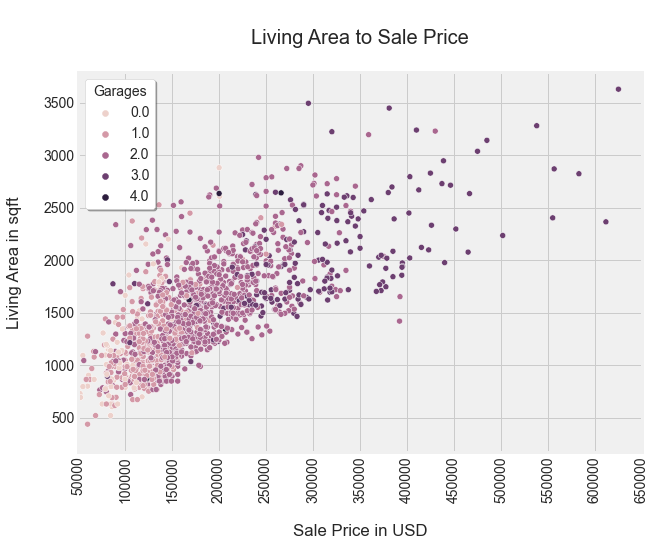

In [73]:
plt.figure(figsize=(9,7))
plt.style.use('fivethirtyeight')
scatter = sns.scatterplot(x='SalePrice', y='LivingSF', data=dfviz, hue='GarageCars')
plt.xticks(np.arange(0, max(dfviz.SalePrice)+1, 50000))
plt.title('\nLiving Area to Sale Price\n', size=20)
plt.ylabel('Living Area in sqft\n')
plt.xlabel('\nSale Price in USD')
plt.xticks(rotation='vertical')
scatter.legend(title='Garages', shadow=True, facecolor='white')
scatter.set_xlim(left=50000, right= 650000);


### Part 3: Feature Creation



##### Quantitative Features


The following step is to transform the qualitative features. For this I have chosen the Box Cox 1 + X transformation, giving me the ability to use it in data that carries a lot of zeros as entries.
<br>
<br>
In the case of the dependent variable, I have used a simple Box Cox transformation in order to get the best value for lambda which the process in python gives you as part of the output for applying Box Cox on a feature. I will need this value to decode the predictions from our model.
<br>

But before that, we check the skewness of the feature and focus our transformation efforts only on columns that show skewness of over 0.70.

In [74]:
dfskews = dftrain[quant_feats]
dfskewstest = dftest[quant_feats]

# Function to check the skewness of quantitative features. Will only output when skewness is 0.7 or over
def skew_check(df):
    skews = pd.DataFrame(columns=['Feature', 'Skewness'])
    for feat in df.columns:
        df[feat].skew()
        
        vals = df[feat].value_counts(dropna=False, normalize=True)
        skews = skews.append({'Feature':feat, 'Skewness':abs(df[feat].skew().round(4))}, ignore_index=True)
    
    return skews[skews.Skewness >= 0.7].sort_values(by='Skewness', ascending=False)

skew_table = skew_check(dfskews)
skew_table

,Feature,Skewness
0,LotArea,12.5876
3,MasVnrArea,2.6575
10,OpenPorchSF,2.3398
13,LivingSF,0.7702



##### Box Cox transformation of quantitative features


Before we start working on other converstions, we set aside and convert our dependent variable. This process will also yield a lambda which will be used to decode the results into actual predictions.
<br>

In [75]:
from scipy.stats import boxcox
from scipy.special import boxcox1p, inv_boxcox1p, inv_boxcox

# Separating the dependent variable so we have the lambda for decoding later
bcox_y, lam_y = boxcox(dftrain.SalePrice)
dftrain.loc[:,'SalePrice']= bcox_y

In [76]:
# Transform the selected features with high skewness using Box Cox 1 + x. 

qualfeat_iter = [feat for feat in skew_table.Feature]

for feat in qualfeat_iter:
    bcox_series= boxcox1p(dfskews[feat], lam_y)
    dftrain.loc[:,feat] = bcox_series

for testfeat in qualfeat_iter:
    bcox_test = boxcox1p(dfskewstest.loc[:,testfeat], lam_y)
    dftest.loc[:,testfeat] = bcox_test
    

Finally in the process of checking and transforming distributions, we take a look at the graphs to visually inspect that the values are not deceptive.
<br>

<Figure size 432x288 with 0 Axes>

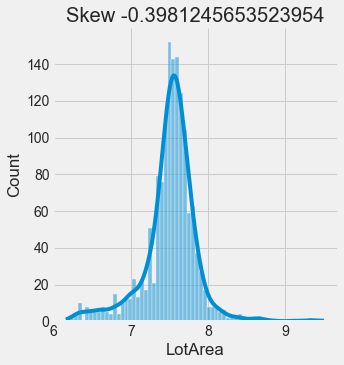

<Figure size 432x288 with 0 Axes>

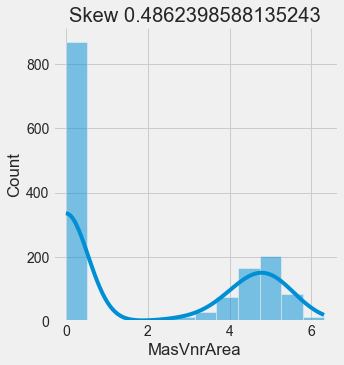

<Figure size 432x288 with 0 Axes>

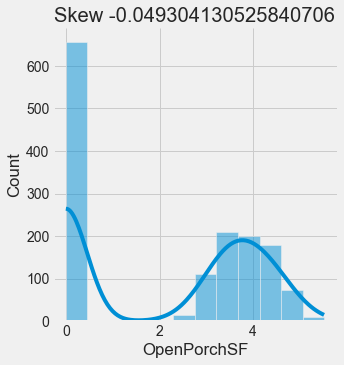

<Figure size 432x288 with 0 Axes>

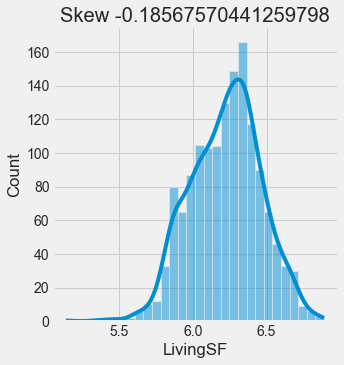

In [77]:
# Performing a visual check of the distributions of the transformed quantitative features

for column in qualfeat_iter:
    try: 
        plt.figure()
        sns.displot(dftrain[column], kde=True)
        plt.title('Skew '+str(dftrain[column].skew()))
    except:
        pass

<br>
It seems that even after transformation OpenPorchSF and MasVnrArea are still far from normal thanks to the amount of value 0 responses. There is more risk than value to continue using them in the model creation.
<br>

In [78]:
# Removing features we no longer want to use from the list we've been working with

quant_feats.remove('OpenPorchSF')
quant_feats.remove('MasVnrArea')


##### Qualitative Features and Setting Up Arrays for Modeling



Using SKLearn OneHotEncoder, and converting our pandas dataframe into numpy arrays, we create concatenated arrays to feed the model creation.
<br>

In [79]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [80]:
# Encoding the qualitative features into logistic/dummy columns
quals_ohe_train = ohe.fit_transform(dftrain[qual_feats])
quals_ohe_test = ohe.transform(dftest[qual_feats])
# quals_ohe_train = ohe.transform(dftrain[qual_feats])

# Converting the quantitative features to match the format used by OneHotEncoder format: np arrays
dftrain_a = dftrain[quant_feats].to_numpy()
dftest_a = dftest[quant_feats].to_numpy()

# Combining the arrays from our encoding with the quantitative features we worked on earlier
dftrain_mod = np.concatenate((quals_ohe_train, dftrain_a), axis=1)
dftest_mod = np.concatenate((quals_ohe_test, dftest_a), axis=1)


#### Part 4: Model Building



Instatiating the model and fitting our numpy arrays to be analyzed by XGBoost. The disabled code at the beginning of this section runs the GridSearch used to find the best parameters. These are a great starting point for when we apply the appropriate test/train split of the training data.
<br>

In [81]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RepeatedKFold
import xgboost

#Different settings to cycle through
# params={
#   "learning_rate":[0.10, 0.15, 0.2],
#   "max_depth":[3, 4, 5, 6, 7],
#   "min_child_weight":[1, 2, 3, 4],
#   "gamma":[0, 0.1],
#   "colsample_bytree":[0.4, 0.5, 0.6]
# }

# # Instantiate the model
# regressor = xgboost.XGBRegressor()

In [82]:
# grid_search= GridSearchCV(regressor, param_grid=params, 
#                           scoring='r2', n_jobs=-1, cv=5)

In [83]:
# grid_search.fit(dftrain_mod, bcox_y)

In [84]:
# grid_search.best_params_

<br>
Using the best value derived from the GridSearch, we continue with the normal process of model fitting and evaluating.
<br>

In [85]:
# Instatiating and fitting XGBoost Regressor with the best parameter found in the GridSearch over the entire data
xgbreg = xgboost.XGBRegressor(colsample_bytree=0.5, gamma=0, learning_rate=0.15, 
                              max_depth=4, min_child_weight=2)

# Splitting the data into test and train
X_train, X_test, y_train, y_test = train_test_split(dftrain_mod, bcox_y, test_size=0.3, random_state=42)

# Fitting the Model
xgbreg.fit(X_train, y_train)

# Define evaluation method
cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=42)

# Evaluate model
scores = cross_val_score(xgbreg, dftrain_mod, bcox_y, cv=cv, n_jobs=-1)
scores.mean()

0.8952109230527587

In [86]:
from sklearn.metrics import mean_squared_error

preds = xgbreg.predict(X_test)
submission_vals = inv_boxcox(preds, lam_y)

print('The Mean Squared Error is ' + str(mean_squared_error(y_test, preds)))

The Mean Squared Error is 0.005894800961666236


<br>
The model clocked an accuracy score of 0.895 and a MSE of 0.006, both of which are good scores overall.
<br>
<br>
To check that our model doesn't have any obvious flaws, we plot the residuals of the model to check that it is largely random and lacking any linear relation.
<br>

/home/andygon/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


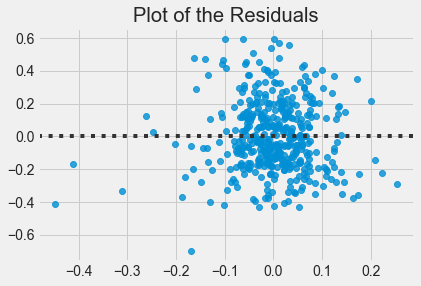

In [87]:
residuals = y_test - preds

sns.residplot(residuals, preds)
plt.title('Plot of the Residuals')
plt.show()

<br>
Finally, zipping the lists together into a csv for submission in Kaggle. Thank you if you made it all the way to the end.
<br>

In [88]:
predictions = xgbreg.predict(dftest_mod)
predictions_conv = inv_boxcox(predictions, lam_y)

submission = pd.DataFrame(zip(dftest.Id, predictions_conv), columns=['Id', 'SalePrice'])
title = pd.DataFrame({'Id':'Id', 'SalePrice':'SalePrice'}, index=[0])
submission = pd.concat([title, submission], ignore_index=True)
submission.to_csv('./aimessubmission.csv', header=None, index=False)
